In [35]:
import numpy as np
import pandas as pd 
import re, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



In [36]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')
# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load data

In [37]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sample_submission.csv')

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Checking shape of the data

In [38]:
df.shape

(159571, 8)

### Checking missing values

In [39]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Checking all class labels and assigning to a variable

In [40]:
comments = df.drop(['id','comment_text'],axis = 1)
comments.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

### Distribution of the target variable data in terms of proportions

In [41]:
for i in list(comments.columns):
    print("Percent of {0}s: ".format(i), round(100*comments[i].mean(),2), "%")

Percent of toxics:  9.58 %
Percent of severe_toxics:  1.0 %
Percent of obscenes:  5.29 %
Percent of threats:  0.3 %
Percent of insults:  4.94 %
Percent of identity_hates:  0.88 %


## Clean the corpus / Data preprocessing

In [42]:
# Function to clean the review text and remove all the unnecessary elements.

def clean_review_text(text):
    '''
    From a string, make text lowercase, remove hyperlinks, word containing numbers.
    Input : a list of strings
    Output : a list of tokens stored in a generator (yield)
    '''
    text = text.lower()  # covert the text to lowercase
    text = re.sub('<.*?>','',text).strip() # remove html chars
    text = re.sub('\[|\(.*\]|\)','', text).strip() # remove text in square brackets and parenthesis
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation marks
    text = re.sub("(\\W)"," ",text).strip() # remove non-ascii chars
    text = re.sub('\S*\d\S*\s*','', text).strip()  # remove words containing numbers
    return text.strip()

In [43]:
%%time
df.comment_text = df.comment_text.astype(str)
df.comment_text = df.comment_text.apply(clean_review_text)


CPU times: user 40.5 s, sys: 625 ms, total: 41.1 s
Wall time: 58.8 s


In [44]:
df.comment_text.head()

0    explanation why the edits made under my userna...
1    daww he matches this background colour im seem...
2    hey man im really not trying to edit war its j...
3    more i cant make any real suggestions on impro...
4    you sir are my hero any chance you remember wh...
Name: comment_text, dtype: object

### Lemmatization

In [45]:
# Snowball stemmer
import nltk
from nltk.stem.snowball import SnowballStemmer

snow_stemmer = SnowballStemmer(language='english')

stopwords = nlp.Defaults.stop_words
def apply_stemmer(text):
    words = text.split()
    sent = [snow_stemmer.stem(word) for word in words if not word in set(stopwords)]
    return ' '.join(sent)

In [46]:
df.comment_text = df.comment_text.apply(apply_stemmer)
df.comment_text.head()

0    explan edit usernam hardcor metallica fan reve...
1    daww match background colour im seem stuck tha...
2    hey man im tri edit war guy constant remov rel...
3    cant real suggest improv wonder section statis...
4                      sir hero chanc rememb page that
Name: comment_text, dtype: object

In [47]:
%%time
# We do the same for the test set
df_test.comment_text = df_test.comment_text.astype(str)
df_test.comment_text = df_test.comment_text.apply(clean_review_text)
df_test.comment_text = df_test.comment_text.apply(apply_stemmer)


CPU times: user 5min, sys: 5.76 s, total: 5min 6s
Wall time: 8min 46s


## Data Split and word embedding

In [48]:
X = df.comment_text
y = df.drop(['id','comment_text'],axis = 1)

In [49]:
# Split the dataset into test and train
from sklearn.model_selection import train_test_split
seed = 100 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [50]:
print(y_train[:5])

        toxic  severe_toxic  obscene  threat  insult  identity_hate
52892       0             0        0       0       0              0
122586      0             0        0       0       0              0
21062       0             0        0       0       0              0
115939      0             0        0       0       0              0
9891        0             0        0       0       0              0


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_union
# Word 
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',            
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),         
    stop_words='english',
    sublinear_tf=True)

# character 
char_vectorizer = TfidfVectorizer(ngram_range =(1,4),
                                 min_df=3, max_df=0.9,
                                 strip_accents='unicode',
                                 analyzer = 'char',
                                 stop_words = 'english',
                                 use_idf=1,
                                 smooth_idf=1,
                                 sublinear_tf=1,
                                 max_features=50000)

vectorizer = make_union(word_vectorizer, char_vectorizer)
vectorizer.fit(X_train)    # Fiting it on Train
train_word_features = vectorizer.transform(X_train)

### transform the split data

In [ ]:
## transforming the train and test datasets
X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

## transforming the complete dataset
X_transformed = vectorizer.transform(X)
# # Print the shape of each dataset.
print('X_transformed', X_transformed.shape)
print('y', y.shape)
print('X_train_transformed', X_train_transformed.shape)
print('y_train', y_train.shape)
print('X_test_transformed', X_test_transformed.shape)
print('y_test', y_test.shape)

## Classification - 1

### Naive Bayes Classifier with method 1 - OneVsRestClassifier

In [ ]:
# Naive Bayes
time1 = time.time()
class_names = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()


# fit model
classifier_ovr_log_nb = OneVsRestClassifier(naive_bayes)
classifier_ovr_log_nb.fit(X_train_transformed, y_train)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

y_train_pred_proba_nb = classifier_ovr_log_nb.predict(X_train_transformed)
y_test_pred_proba_nb = classifier_ovr_log_nb.predict(X_test_transformed)

from sklearn.metrics import accuracy_score

print("Accuracy Train:", accuracy_score(y_train, y_train_pred_proba_nb))
print("Accuracy Test:", accuracy_score(y_test, y_test_pred_proba_nb))


Time Taken: 16.66 seconds
Accuracy Train: 0.8978113053832174
Accuracy Test: 0.9010496631677894


#### Performance metrics

In [ ]:
# Precision, recall and f1-score
print("Combined Performanc metrics:")
print(classification_report(y_test, y_test_pred_proba_nb))

Combined Performanc metrics:
              precision    recall  f1-score   support

           0       1.00      0.02      0.05      2988
           1       0.00      0.00      0.00       303
           2       1.00      0.01      0.03      1624
           3       0.00      0.00      0.00        90
           4       0.75      0.00      0.00      1503
           5       0.00      0.00      0.00       277

   micro avg       0.99      0.01      0.03      6785
   macro avg       0.46      0.01      0.01      6785
weighted avg       0.85      0.01      0.03      6785
 samples avg       0.00      0.00      0.00      6785



#### confusion matrix for the above predicted results

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
# toxic  severe_toxic  obscene  threat  insult  identity_hate
#     
#           False      True
#            0           1    
# False 0  True -ve   False +ve
# True  1  False -ve  True +ve
cm_matrix = multilabel_confusion_matrix(y_test, y_test_pred_proba_nb)
print(cm_matrix)

[[[28927     0]
  [ 2919    69]]

 [[31612     0]
  [  303     0]]

 [[30291     0]
  [ 1602    22]]

 [[31825     0]
  [   90     0]]

 [[30411     1]
  [ 1500     3]]

 [[31638     0]
  [  277     0]]]


#### plotting the confusion matrix

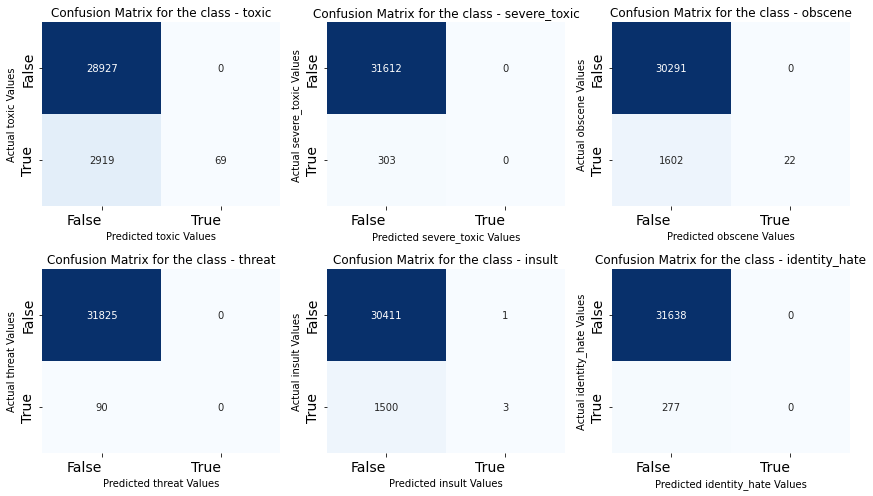

In [ ]:
# labels = ["".join("c" + str(i)) for i in range(0, 6)]
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right', fontsize=fontsize)
    axes.set_ylabel('Actual {} Values'.format(class_label))
    axes.set_xlabel('Predicted {} Values'.format(class_label))
    axes.set_title("Confusion Matrix for the class - " + class_label)

fig, ax = plt.subplots(2,3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm_matrix, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["False", "True"])

    
fig.tight_layout()
plt.show()

### Naive Bayes Classifier with method 2 - Cross Validation

In [ ]:
# Cross validation for train and test data.
val_score = []
def cross_validation(model,y):
    score = cross_val_score(model,X_transformed,y,scoring='accuracy',cv=5)
    val_score.append(score.mean())

In [ ]:
for clas in class_names:
    cross_validation(naive_bayes,y[clas])

NB_score = val_score


#### Displaying mean accuracy for all the class labels 

In [ ]:
DF_score = pd.DataFrame(index=class_names)
DF_score['NB'] = NB_score
DF_score

,NB
toxic,0.906136
severe_toxic,0.990004
obscene,0.947741
threat,0.997004
insult,0.950687
identity_hate,0.991195


### Naive Bayes Classifier with method 3
#### Calculated separately for every label

---- Processing toxic ----
Training accuracy is 0.9058955317415555
Testing accuracy is 0.9085383048723171


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     28927
           1       1.00      0.02      0.05      2988

    accuracy                           0.91     31915
   macro avg       0.95      0.51      0.50     31915
weighted avg       0.92      0.91      0.87     31915



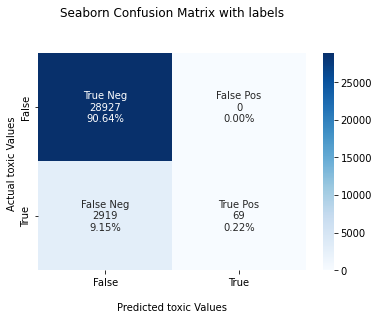

---- Processing severe_toxic ----
Training accuracy is 0.9898790499467318
Testing accuracy is 0.9905060316465611


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31612
           1       0.00      0.00      0.00       303

    accuracy                           0.99     31915
   macro avg       0.50      0.50      0.50     31915
weighted avg       0.98      0.99      0.99     31915



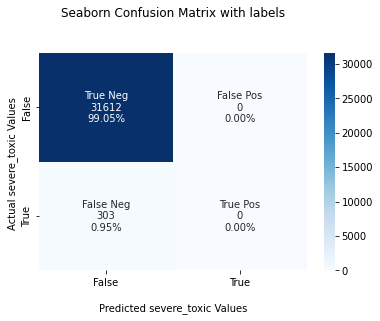

---- Processing obscene ----
Training accuracy is 0.9473115247226922
Testing accuracy is 0.9498041673194423


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     30291
           1       1.00      0.01      0.03      1624

    accuracy                           0.95     31915
   macro avg       0.97      0.51      0.50     31915
weighted avg       0.95      0.95      0.93     31915



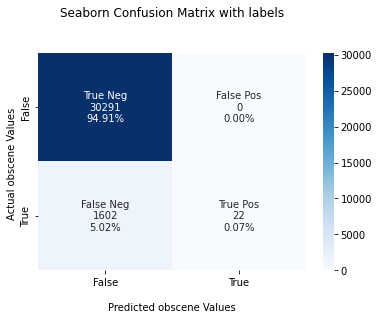

---- Processing threat ----
Training accuracy is 0.9969605815629504
Testing accuracy is 0.9971800093999686


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31825
           1       0.00      0.00      0.00        90

    accuracy                           1.00     31915
   macro avg       0.50      0.50      0.50     31915
weighted avg       0.99      1.00      1.00     31915



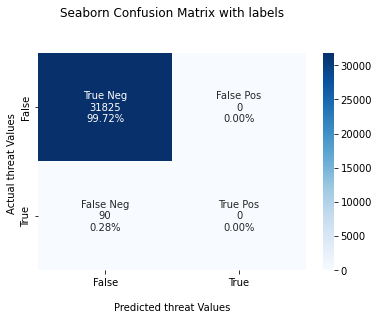

---- Processing insult ----
Training accuracy is 0.9501159365795575
Testing accuracy is 0.9529688234372552


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     30412
           1       0.75      0.00      0.00      1503

    accuracy                           0.95     31915
   macro avg       0.85      0.50      0.49     31915
weighted avg       0.94      0.95      0.93     31915



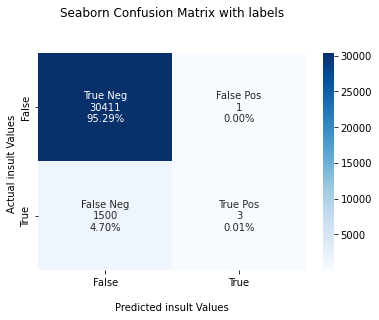

---- Processing identity_hate ----
Training accuracy is 0.9911637525850724
Testing accuracy is 0.9913206955976813


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31638
           1       0.00      0.00      0.00       277

    accuracy                           0.99     31915
   macro avg       0.50      0.50      0.50     31915
weighted avg       0.98      0.99      0.99     31915



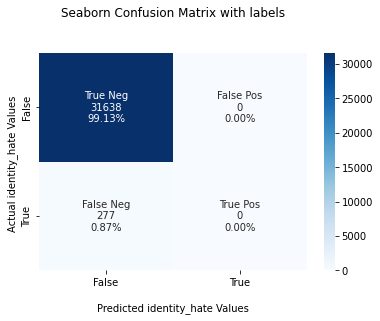

In [ ]:
from sklearn.metrics import confusion_matrix
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

naive_bayes_model = MultinomialNB()

for label in cols_target:
    print('---- Processing {} ----'.format(label))
    y_nb = y_train[label]
    y1_nb = y_test[label]
    # train the model using train data
    naive_bayes_model.fit(X_train_transformed, y_nb)
    # compute the training accuracy
    y_pred_X = naive_bayes_model.predict(X_train_transformed)
    print('Training accuracy is {}'.format(accuracy_score(y_nb, y_pred_X)))
    # compute the predicted probabilities test data
    test_y_prob = naive_bayes_model.predict(X_test_transformed)
    print('Testing accuracy is {}'.format(accuracy_score(y1_nb, test_y_prob)))
    print('\n')
    # Precision, recall and f1-score
    print("Combined Performanc metrics:")
    print(classification_report(y1_nb, test_y_prob))
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y1_nb,test_y_prob)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted {} Values'.format(label))
    ax.set_ylabel('Actual {} Values '.format(label));

    ## Ticket labels
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()


## Classification - 2
### Logistic Regression Classifier with method 1 - OneVsRestClassifier

In [ ]:
# Logistic Regression 
time1 = time.time()
# logistic regression
log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=seed)

# fit model
classifier_ovr_log = OneVsRestClassifier(log_reg)
classifier_ovr_log.fit(X_train_transformed, y_train)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

y_train_pred_proba = classifier_ovr_log.predict_proba(X_train_transformed)
y_test_pred_proba = classifier_ovr_log.predict_proba(X_test_transformed)


roc_auc_score_train = roc_auc_score(y_train, y_train_pred_proba,average='weighted')
roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba,average='weighted')

print("ROC AUC Score Train:", roc_auc_score_train)
print("ROC AUC Score Test:", roc_auc_score_test)


Time Taken: 329.56 seconds
ROC AUC Score Train: 0.9999177375137026
ROC AUC Score Test: 0.9799509159902606


### Logistic Regression Classifier with method 2
#### Calculated separately for every label

---- Processing toxic ----
Training accuracy is 0.9989738045998622
Testing accuracy is 0.9621494595018016


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28927
           1       0.87      0.70      0.78      2988

    accuracy                           0.96     31915
   macro avg       0.92      0.84      0.88     31915
weighted avg       0.96      0.96      0.96     31915



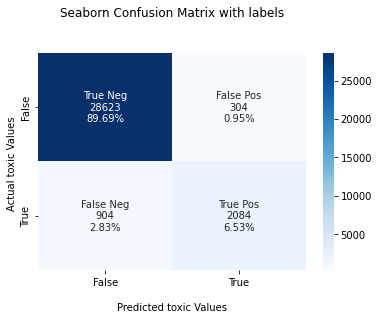

---- Processing severe_toxic ----
Training accuracy is 0.9994516513129035
Testing accuracy is 0.990224032586558


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31612
           1       0.47      0.26      0.34       303

    accuracy                           0.99     31915
   macro avg       0.73      0.63      0.67     31915
weighted avg       0.99      0.99      0.99     31915



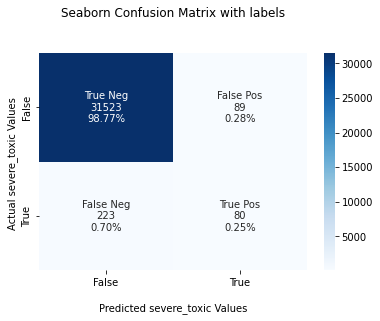

---- Processing obscene ----
Training accuracy is 0.999224478285392
Testing accuracy is 0.9808867303775655


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     30291
           1       0.88      0.72      0.79      1624

    accuracy                           0.98     31915
   macro avg       0.93      0.86      0.89     31915
weighted avg       0.98      0.98      0.98     31915



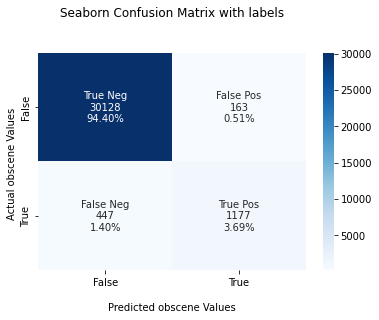

---- Processing threat ----
Training accuracy is 0.9999059973679263
Testing accuracy is 0.9975560081466395


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31825
           1       0.71      0.22      0.34        90

    accuracy                           1.00     31915
   macro avg       0.86      0.61      0.67     31915
weighted avg       1.00      1.00      1.00     31915



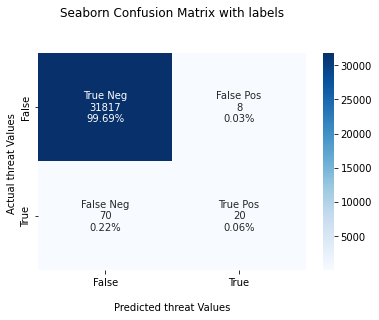

---- Processing insult ----
Training accuracy is 0.9987466315723507
Testing accuracy is 0.9720820930596898


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     30412
           1       0.77      0.58      0.66      1503

    accuracy                           0.97     31915
   macro avg       0.87      0.79      0.82     31915
weighted avg       0.97      0.97      0.97     31915



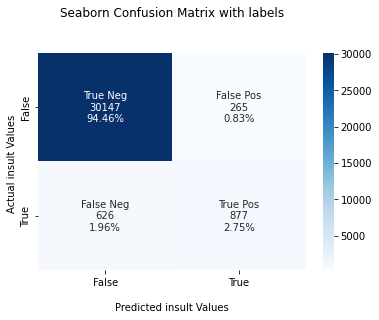

---- Processing identity_hate ----
Training accuracy is 0.9997649934198157
Testing accuracy is 0.9926680244399185


Combined Performanc metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31638
           1       0.65      0.33      0.44       277

    accuracy                           0.99     31915
   macro avg       0.82      0.66      0.72     31915
weighted avg       0.99      0.99      0.99     31915



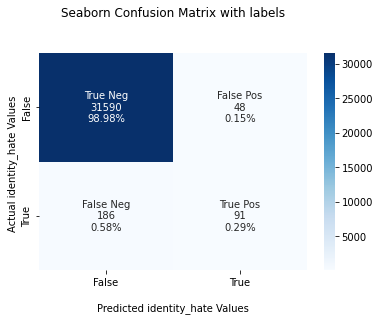

In [ ]:
from sklearn.metrics import confusion_matrix
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
lr_model = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=seed)

for label in cols_target:
    print('---- Processing {} ----'.format(label))
    y_train_lr = y_train[label]
    y_test_lr = y_test[label]
    # train the model using train data
    lr_model.fit(X_train_transformed, y_train_lr)
    # compute the training accuracy
    y_pred_X_lr = lr_model.predict(X_train_transformed)
    print('Training accuracy is {}'.format(accuracy_score(y_train_lr, y_pred_X_lr)))
    # compute the predicted probabilities for test data
    test_y_prob = lr_model.predict(X_test_transformed)
    print('Testing accuracy is {}'.format(accuracy_score(y_test_lr, test_y_prob)))
    print('\n')
    # Precision, recall and f1-score
    print("Combined Performanc metrics:")
    print(classification_report(y_test_lr, test_y_prob))
    #Generate the confusion matrix
    cf_matrix_lr = confusion_matrix(y_test_lr,test_y_prob)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix_lr.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix_lr.flatten()/np.sum(cf_matrix_lr)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix_lr, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted {} Values'.format(label))
    ax.set_ylabel('Actual {} Values '.format(label));

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()


## Calculate the percentage of toxicity in test.csv

In [ ]:
classifier = classifier_ovr_log

In [ ]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succes youll what hate sad mo...
1,0000247867823ef7,rfc titl fine imo
2,00013b17ad220c46,sourc zaw ashton lapland
3,00017563c3f7919a,look sourc inform updat correct form guess sou...
4,00017695ad8997eb,dont anonym edit articl


In [ ]:
def make_test_predictions(df,classifier):
    X_test = df.comment_text
    X_test_transformed = word_vectorizer.transform(X_test)
    y_test_pred = classifier.predict_proba(X_test_transformed)
    y_test_pred_df = pd.DataFrame(y_test_pred,columns=comments.columns)
    submission_df = pd.concat([df.id, y_test_pred_df], axis=1)
    submission_df.to_csv('submission1.csv', index = False)

In [ ]:
make_test_predictions(df_test,classifier_ovr_log)

ValueError: X has 4771536 features, but LogisticRegression is expecting 4821536 features as input.